# 自建GPT训练流程 - Part 5: 评估与对比

## 概述

本notebook对整个训练流程中产生的三个模型进行系统评估和对比：

**设备建议：** CPU 可跑。

```
Base模型（预训练） → SFT模型（指令微调） → DPO模型（偏好对齐）
```

### 评估维度

| 维度 | 指标 | 说明 |
|------|------|------|
| **语言建模能力** | 困惑度 (Perplexity) | 越低越好 |
| **指令遵循能力** | 任务准确率 | 短问答可自动评估 |
| **生成质量** | 流畅度、多样性 | Distinct-n | 
| **偏好一致性** | 选择好回答的比例 | 人类偏好对齐 |


## 环境设置

In [73]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.auto import tqdm
import os
import sys
import re
from collections import Counter
plt.rcParams["font.sans-serif"] = ["Microsoft YaHei", "SimHei", "Noto Sans CJK SC", "Arial Unicode MS"]
plt.rcParams["axes.unicode_minus"] = False


# 兼容从项目根目录或本目录运行
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), "..")) if os.path.basename(os.getcwd()) == "Custom_GPT_Training" else os.getcwd()
CUSTOM_GPT_DIR = os.path.join(PROJECT_ROOT, "Custom_GPT_Training")
sys.path.insert(0, CUSTOM_GPT_DIR)

from custom_gpt import (
    CustomGPT, 
    GPTConfig, 
    SimpleTokenizer,
    count_parameters
)

# 设备选择
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"使用设备: {device}")

# 可复现性
torch.manual_seed(42)
np.random.seed(42)

使用设备: cuda


## Part 1: 加载所有模型

In [74]:
CHECKPOINT_DIR = os.path.join(PROJECT_ROOT, "models", "custom_gpt")

# 加载tokenizer
tokenizer = SimpleTokenizer.load(os.path.join(CHECKPOINT_DIR, "tokenizer.pkl"))
print(f"Tokenizer词表大小: {len(tokenizer)}")

# 加载三个阶段的模型
models = {}

model_paths = {
    'Base (预训练)': 'pretrained_model',
    'SFT (指令微调)': 'sft_model',
    'DPO (偏好对齐)': 'dpo_model'
}

print("\n加载模型:")
for name, path in model_paths.items():
    full_path = os.path.join(CHECKPOINT_DIR, path)
    if os.path.exists(full_path):
        models[name] = CustomGPT.from_pretrained(full_path).to(device)
        models[name].eval()
        print(f"  ✓ {name}: {count_parameters(models[name])}")
    else:
        print(f"  ✗ {name}: 不存在")

print(f"\n成功加载 {len(models)} 个模型")

Tokenizer词表大小: 381

加载模型:
Model loaded from c:\Users\lvbab\Documents\GitHub\LLM-Agent-Core_Concept_Code\models\custom_gpt\pretrained_model
  ✓ Base (预训练): 14.31M
Model loaded from c:\Users\lvbab\Documents\GitHub\LLM-Agent-Core_Concept_Code\models\custom_gpt\sft_model
  ✓ SFT (指令微调): 14.31M
Model loaded from c:\Users\lvbab\Documents\GitHub\LLM-Agent-Core_Concept_Code\models\custom_gpt\dpo_model
  ✓ DPO (偏好对齐): 14.31M

成功加载 3 个模型


## Part 2: 困惑度评估 (Perplexity)

In [75]:
# 评估用测试文本
TEST_TEXTS = [
    "深度学习是机器学习的一个重要分支，使用多层神经网络来学习数据的表示。",
    "Transformer架构通过自注意力机制实现了并行计算，大大提高了训练效率。",
    "预训练语言模型首先在大规模语料上学习通用知识，然后针对具体任务进行微调。",
    "强化学习通过与环境的交互来学习最优策略，智能体通过奖励信号不断改进。",
    "注意力机制让模型能够动态关注输入的不同部分，是现代NLP的核心技术。",
    "梯度下降算法通过计算损失函数对参数的梯度来更新模型参数。",
    "过拟合是模型在训练数据上表现很好但在新数据上表现差的现象。",
    "正则化技术如Dropout和权重衰减可以有效防止模型过拟合。",
]

print(f"测试文本数量: {len(TEST_TEXTS)}")

测试文本数量: 8


In [76]:
@torch.no_grad()
def compute_perplexity(model, tokenizer, texts):
    """
    计算模型在文本集上的困惑度
    
    困惑度 = exp(平均交叉熵损失)
    """
    model.eval()
    total_loss = 0
    total_tokens = 0
    
    for text in texts:
        # 编码
        ids = tokenizer.encode(text, add_bos=True, add_eos=True)
        if len(ids) < 2:
            continue
        
        input_ids = torch.tensor([ids[:-1]]).to(device)
        labels = torch.tensor([ids[1:]]).to(device)
        
        # 前向传播
        outputs = model(input_ids)
        logits = outputs['logits']
        
        # 计算交叉熵
        loss = F.cross_entropy(
            logits.view(-1, logits.size(-1)),
            labels.view(-1),
            reduction='sum'
        )
        
        total_loss += loss.item()
        total_tokens += labels.numel()
    
    avg_loss = total_loss / total_tokens
    perplexity = np.exp(avg_loss)
    
    return perplexity, avg_loss

In [77]:
# 计算各模型的困惑度
print("模型困惑度对比:")
print("=" * 50)
print("提示: DPO优化人类偏好，困惑度可能上升，这里仍纳入对比。")

ppl_results = {}

for name, model in models.items():
    ppl, loss = compute_perplexity(model, tokenizer, TEST_TEXTS)
    ppl_results[name] = ppl
    print(f"{name}:")
    print(f"  困惑度: {ppl:.2f}")
    print(f"  平均Loss: {loss:.4f}")
    print()

模型困惑度对比:
提示: DPO优化人类偏好，困惑度可能上升，这里仍纳入对比。
Base (预训练):
  困惑度: 568.17
  平均Loss: 6.3424

SFT (指令微调):
  困惑度: 504.94
  平均Loss: 6.2244

DPO (偏好对齐):
  困惑度: 428.21
  平均Loss: 6.0596



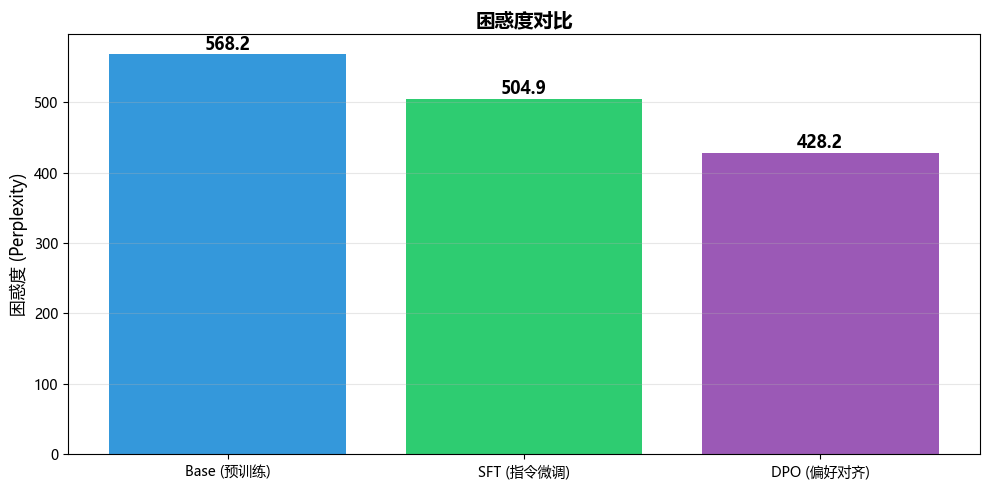


说明: 困惑度越低表示模型对测试文本的预测越准确


In [78]:
# 可视化困惑度对比
if ppl_results:
    fig, ax = plt.subplots(figsize=(10, 5))
    
    names = list(ppl_results.keys())
    values = list(ppl_results.values())
    colors = ['#3498db', '#2ecc71', '#9b59b6']
    
    bars = ax.bar(names, values, color=colors[:len(names)])
    
    # 添加数值标签
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{val:.1f}', ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    ax.set_ylabel('困惑度 (Perplexity)', fontsize=12)
    ax.set_title('困惑度对比', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    print("\n说明: 困惑度越低表示模型对测试文本的预测越准确")

## Part 3: 指令遵循能力评估

In [79]:
# ChatML格式化器
class ChatMLFormatter:
    SYSTEM_PROMPT = "你是一个有帮助的AI助手。"
    SYSTEM_TOKEN = "<|system|>"
    USER_TOKEN = "<|user|>"
    ASSISTANT_TOKEN = "<|assistant|>"
    END_TOKEN = "<|endoftext|>"
    
    @classmethod
    def format_prompt_only(cls, instruction, include_system=True):
        parts = []
        if include_system:
            parts.append(f"{cls.SYSTEM_TOKEN}{cls.SYSTEM_PROMPT}{cls.END_TOKEN}")
        parts.append(f"{cls.USER_TOKEN}{instruction}{cls.END_TOKEN}")
        parts.append(f"{cls.ASSISTANT_TOKEN}")
        return "\n".join(parts)

In [80]:
def generate_response(model, tokenizer, instruction, max_new_tokens=80, temperature=0.7, use_chatml=True, do_sample=True):
    """
    生成回答

    use_chatml=True: 使用ChatML格式（适合SFT/DPO模型）
    use_chatml=False: 直接续写（适合Base模型）
    """
    model.eval()

    if use_chatml:
        prompt = ChatMLFormatter.format_prompt_only(instruction)
    else:
        prompt = instruction

    input_ids = torch.tensor([tokenizer.encode(prompt, add_bos=True, add_eos=False)]).to(device)

    with torch.no_grad():
        output_ids = model.generate(
            input_ids,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            top_k=50,
            do_sample=do_sample
        )

    full_response = tokenizer.decode(output_ids[0].tolist())

    # 提取回答部分
    if use_chatml and ChatMLFormatter.ASSISTANT_TOKEN in full_response:
        response = full_response.split(ChatMLFormatter.ASSISTANT_TOKEN)[-1]
        if ChatMLFormatter.END_TOKEN in response:
            response = response.split(ChatMLFormatter.END_TOKEN)[0]
    else:
        # 对于Base模型，返回生成的部分
        prompt_decoded = tokenizer.decode(input_ids[0].tolist())
        response = full_response[len(prompt_decoded):]

    return response.strip()


In [81]:
# 评估任务集（从 data/ 读取，保证与训练分离）
import json
from pathlib import Path

def resolve_data_dir():
    candidates = [Path.cwd(), Path.cwd().parent]
    for base in candidates:
        data_dir = base / "data"
        if data_dir.exists():
            return str(data_dir)
    return os.path.join(os.getcwd(), "data")

DATA_DIR = resolve_data_dir()

# 评估速度控制（减小样本数可显著加速）
MAX_EVAL_TASKS = 200
MAX_PREFERENCE_TEST = 200
MAX_DIVERSITY_PROMPTS = 3
DIVERSITY_SAMPLES_PER_PROMPT = 1


def load_jsonl(path):
    with open(path, "r", encoding="utf-8-sig") as f:
        return [json.loads(line) for line in f if line.strip()]

TEST_TASKS = load_jsonl(os.path.join(DATA_DIR, "custom_sft_test.jsonl"))
PREFERENCE_TEST = load_jsonl(os.path.join(DATA_DIR, "custom_dpo_test.jsonl"))

TEST_TASKS = TEST_TASKS[:MAX_EVAL_TASKS]
PREFERENCE_TEST = PREFERENCE_TEST[:MAX_PREFERENCE_TEST]

print(f"评估任务数: {len(TEST_TASKS)} | 偏好对数: {len(PREFERENCE_TEST)}")


评估任务数: 200 | 偏好对数: 200


In [82]:
# 对比各模型的回答（可量化评估）

def normalize_text(text):
    return " ".join(text.strip().lower().split())

def extract_number(text):
    match = re.search(r"-?\d+", text)
    return match.group(0) if match else None

def extract_json(text):
    candidate = text.strip()
    if not candidate.startswith('{') or not candidate.endswith('}'):
        return None
    try:
        return json.loads(candidate)
    except Exception:
        return None

TEXT_SIM_THRESHOLD = 0.5

def char_f1(a, b):
    if not a or not b:
        return 0.0
    ca = Counter(a)
    cb = Counter(b)
    overlap = sum((ca & cb).values())
    precision = overlap / max(len(b), 1)
    recall = overlap / max(len(a), 1)
    if precision + recall == 0:
        return 0.0
    return 2 * precision * recall / (precision + recall)

def lcs_ratio(a, b):
    if not a or not b:
        return 0.0
    dp = [0] * (len(b) + 1)
    for i in range(len(a)):
        prev = 0
        for j in range(len(b)):
            temp = dp[j + 1]
            if a[i] == b[j]:
                dp[j + 1] = prev + 1
            else:
                dp[j + 1] = max(dp[j + 1], dp[j])
            prev = temp
    return dp[-1] / max(len(a), 1)

def bigram_recall(a, b):
    if not a:
        return 0.0
    if len(a) < 2:
        return 1.0 if a in b else 0.0
    expected_bigrams = [a[i:i+2] for i in range(len(a) - 1)]
    pred_bigrams = set(b[i:i+2] for i in range(len(b) - 1)) if len(b) >= 2 else set()
    hits = sum(1 for bg in expected_bigrams if bg in pred_bigrams)
    return hits / max(len(expected_bigrams), 1)

def score_prediction(pred, task):
    pred_norm = normalize_text(pred)
    expected = task["expected"]
    expected_norm = normalize_text(expected)
    metric = task["metric"]

    if metric == "numeric":
        return extract_number(pred_norm) == expected

    if metric == "json":
        pred_obj = extract_json(pred)
        try:
            expected_obj = json.loads(expected)
        except Exception:
            expected_obj = None
        return pred_obj == expected_obj

    # 文本任务：允许相似表达（字符级F1 / LCS / bigram recall）
    if expected_norm in pred_norm:
        return True
    f1 = char_f1(expected_norm, pred_norm)
    lcs = lcs_ratio(expected_norm, pred_norm)
    recall = bigram_recall(expected_norm, pred_norm)
    return max(f1, lcs, recall) >= TEXT_SIM_THRESHOLD

def evaluate_instruction_following(model, tasks, use_chatml):
    results = {}
    samples = []
    for task in tasks:
        pred = generate_response(
            model,
            tokenizer,
            task["instruction"],
            max_new_tokens=40,
            temperature=1.0,
            use_chatml=use_chatml,
            do_sample=False
        )
        correct = score_prediction(pred, task)
        results.setdefault(task["category"], []).append(correct)
        if len(samples) < 3:
            samples.append((task["instruction"], task["expected"], pred))

    summary = {cat: sum(vals) / len(vals) for cat, vals in results.items()}
    summary["overall"] = sum(sum(v) for v in results.values()) / sum(len(v) for v in results.values())
    return summary, samples

print(f"指令遵循能力对比 (文本相似度阈值={TEXT_SIM_THRESHOLD:.2f}, F1/LCS/BigramRecall):")
print("=" * 80)

instruction_results = {}

for name, model in models.items():
    use_chatml = 'Base' not in name
    summary, samples = evaluate_instruction_following(model, TEST_TASKS, use_chatml)
    instruction_results[name] = summary

    print(f"\n{name}:")
    for cat, acc in summary.items():
        print(f"  {cat}: {acc*100:.1f}%" if cat != "overall" else f"  overall: {acc*100:.1f}%")

    print("  示例:")
    for ins, exp, pred in samples:
        print(f"    Q: {ins}")
        print(f"    Expected: {exp}")
        print(f"    Pred: {pred[:80]}")

print("\n" + "=" * 80)


指令遵循能力对比 (文本相似度阈值=0.50, F1/LCS/BigramRecall):

Base (预训练):
  知识问答: 0.0%
  overall: 0.0%
  示例:
    Q: 用一句话解释：深度学习是什么？
    Expected: 深度学习是用多层神经网络学习数据表示的方法。
    Pred: 。征程要置证与停
    Q: 用不超过40字回答：机器学习是什么？
    Expected: 机器学习是让模型从数据中学习规律并做预测。
    Pred: 学数准学数准学学率。据备学是是是是是据致。据备先虑行本资。据备先虑行本资。
    Q: 简要说明：监督学习是什么？
    Expected: 监督学习用带标签的数据训练模型。
    Pred: 。征程要置证与停

SFT (指令微调):
  知识问答: 100.0%
  overall: 100.0%
  示例:
    Q: 用一句话解释：深度学习是什么？
    Expected: 深度学习是用多层神经网络学习数据表示的方法。
    Pred: 深度学习是用多层神经网络学习数据表示的方法。
    Q: 用不超过40字回答：机器学习是什么？
    Expected: 机器学习是让模型从数据中学习规律并做预测。
    Pred: 机器学习是让模型从数据中学习规律并做预测。
    Q: 简要说明：监督学习是什么？
    Expected: 监督学习用带标签的数据训练模型。
    Pred: 监督学习用带标签的数据训练模型。

DPO (偏好对齐):
  知识问答: 83.0%
  overall: 83.0%
  示例:
    Q: 用一句话解释：深度学习是什么？
    Expected: 深度学习是用多层神经网络学习数据表示的方法。
    Pred: 深度学习是模型从数据中学习数据表示的方法。
    Q: 用不超过40字回答：机器学习是什么？
    Expected: 机器学习是让模型从数据中学习规律并做预测。
    Pred: 机器学习是模型从数据中学习规律并做预测。
    Q: 简要说明：监督学习是什么？
    Expected: 监督学习用带标签的数据训练模型。
    Pred: 监督学习用带标签的数据训练模型。



## Part 4: 生成多样性评估

In [83]:
def compute_diversity(responses):
    """
    计算生成多样性
    
    使用distinct n-gram比例
    """
    all_unigrams = []
    all_bigrams = []
    
    for response in responses:
        tokens = list(response)  # 字符级
        all_unigrams.extend(tokens)
        all_bigrams.extend(zip(tokens[:-1], tokens[1:]))
    
    if len(all_unigrams) == 0:
        return 0, 0
    
    distinct_1 = len(set(all_unigrams)) / len(all_unigrams)
    distinct_2 = len(set(all_bigrams)) / len(all_bigrams) if all_bigrams else 0
    
    return distinct_1, distinct_2

In [84]:
# 为多个问题生成回答评估多样性
print("生成多样性评估:")
print("=" * 50)

diversity_results = {}

DIVERSITY_PROMPTS = [t["instruction"] for t in TEST_TASKS[:MAX_DIVERSITY_PROMPTS]]

for name, model in models.items():
    responses = []
    use_chatml = 'Base' not in name

    for prompt in DIVERSITY_PROMPTS:
        for _ in range(DIVERSITY_SAMPLES_PER_PROMPT):
            response = generate_response(
                model, tokenizer, prompt,
                temperature=0.8,
                use_chatml=use_chatml,
                do_sample=True
            )
            responses.append(response)

    distinct_1, distinct_2 = compute_diversity(responses)
    diversity_results[name] = (distinct_1, distinct_2)

    print(f"\n{name}:")
    print(f"  Distinct-1 (字符级): {distinct_1:.4f}")
    print(f"  Distinct-2 (bigram): {distinct_2:.4f}")
    print(f"  平均回答长度: {np.mean([len(r) for r in responses]):.1f}字符")


生成多样性评估:

Base (预训练):
  Distinct-1 (字符级): 0.6667
  Distinct-2 (bigram): 0.8485
  平均回答长度: 12.0字符

SFT (指令微调):
  Distinct-1 (字符级): 0.6780
  Distinct-2 (bigram): 0.8571
  平均回答长度: 19.7字符

DPO (偏好对齐):
  Distinct-1 (字符级): 0.5789
  Distinct-2 (bigram): 0.7222
  平均回答长度: 19.0字符


## Part 5: 偏好一致性评估

In [85]:
# 偏好测试数据（结构化“要点”风格偏好）
print(f"偏好测试对数: {len(PREFERENCE_TEST)}")


偏好测试对数: 200


In [86]:
@torch.no_grad()
def compute_response_prob(model, tokenizer, prompt, response):
    """
    计算给定prompt下response的对数概率
    """
    model.eval()
    
    # 使用ChatML格式
    full_text = ChatMLFormatter.format_prompt_only(prompt) + response + ChatMLFormatter.END_TOKEN
    prompt_text = ChatMLFormatter.format_prompt_only(prompt)
    
    full_ids = tokenizer.encode(full_text, add_bos=True, add_eos=False)
    prompt_ids = tokenizer.encode(prompt_text, add_bos=True, add_eos=False)
    
    response_start = len(prompt_ids)
    
    input_ids = torch.tensor([full_ids[:-1]]).to(device)
    labels = torch.tensor([full_ids[1:]]).to(device)
    
    outputs = model(input_ids)
    logits = outputs['logits']
    
    log_probs = F.log_softmax(logits, dim=-1)
    per_token_log_probs = torch.gather(log_probs, dim=-1, index=labels.unsqueeze(-1)).squeeze(-1)
    
    # 只计算response部分
    response_log_prob = per_token_log_probs[0, response_start-1:].sum().item()
    
    return response_log_prob

In [87]:
# 评估偏好一致性
print("偏好一致性评估:")
print("=" * 60)
print("(模型是否更倾向于chosen回答而非rejected回答)")

preference_results = {name: [] for name in models.keys()}

for item in PREFERENCE_TEST:
    for name, model in models.items():
        chosen_prob = compute_response_prob(model, tokenizer, item['prompt'], item['chosen'])
        rejected_prob = compute_response_prob(model, tokenizer, item['prompt'], item['rejected'])

        prefers_chosen = chosen_prob > rejected_prob
        preference_results[name].append(prefers_chosen)

        symbol = "OK" if prefers_chosen else "NO"
print("\n" + "=" * 60)
print("\n偏好一致性总结:")
for name, results in preference_results.items():
    accuracy = sum(results) / len(results) * 100
    print(f"  {name}: {accuracy:.1f}% ({sum(results)}/{len(results)})")


偏好一致性评估:
(模型是否更倾向于chosen回答而非rejected回答)


偏好一致性总结:
  Base (预训练): 0.0% (0/200)
  SFT (指令微调): 0.0% (0/200)
  DPO (偏好对齐): 100.0% (200/200)


## Part 6: 综合评估报告

In [88]:
# 创建综合评估表格
print("\n" + "=" * 80)
print("                       综合评估报告")
print("=" * 80)

# 准备数据
metrics = []
report_data = []

for name in models.keys():
    ppl = ppl_results.get(name)
    instr = instruction_results.get(name, {}).get('overall') if name in instruction_results else None
    distinct_1, distinct_2 = diversity_results.get(name, (None, None)) if name in diversity_results else (None, None)
    pref = sum(preference_results[name]) / len(preference_results[name]) if name in preference_results else None
    diversity_avg = None if distinct_1 is None or distinct_2 is None else (distinct_1 + distinct_2) / 2

    metrics.append({
        'model': name,
        'ppl': ppl,
        'instr': instr,
        'pref': pref,
        'distinct_1': distinct_1,
        'distinct_2': distinct_2,
        'diversity_avg': diversity_avg
    })

def normalize(values, higher_better=True):
    vals = [v for v in values if v is not None]
    if not vals:
        return [None for _ in values]
    vmin, vmax = min(vals), max(vals)
    if vmax == vmin:
        return [1.0 if v is not None else None for v in values]
    normed = []
    for v in values:
        if v is None:
            normed.append(None)
            continue
        n = (v - vmin) / (vmax - vmin)
        normed.append(n if higher_better else 1 - n)
    return normed

ppl_vals = [m['ppl'] for m in metrics]
instr_vals = [m['instr'] for m in metrics]
pref_vals = [m['pref'] for m in metrics]
div_vals = [m['diversity_avg'] for m in metrics]

ppl_norm = normalize(ppl_vals, higher_better=False)
instr_norm = normalize(instr_vals, higher_better=True)
pref_norm = normalize(pref_vals, higher_better=True)
div_norm = normalize(div_vals, higher_better=True)

for i, m in enumerate(metrics):
    weights = {'instr': 0.35, 'pref': 0.35, 'div': 0.2, 'ppl': 0.1}
    score = 0.0
    total = 0.0
    if instr_norm[i] is not None:
        score += weights['instr'] * instr_norm[i]
        total += weights['instr']
    if pref_norm[i] is not None:
        score += weights['pref'] * pref_norm[i]
        total += weights['pref']
    if div_norm[i] is not None:
        score += weights['div'] * div_norm[i]
        total += weights['div']
    if ppl_norm[i] is not None:
        score += weights['ppl'] * ppl_norm[i]
        total += weights['ppl']
    overall = score / total if total > 0 else None
    m['overall'] = overall

    report_data.append({
        '模型': m['model'],
        '综合得分': m['overall'],
        '指令准确率': m['instr'],
        '偏好一致性': m['pref'],
        'Distinct-1': m['distinct_1'],
        'Distinct-2': m['distinct_2'],
        '困惑度': m['ppl']
    })

# 打印表格
df = pd.DataFrame(report_data)
df = df.sort_values(by='综合得分', ascending=False, na_position='last')
display_df = df.copy()
display_df['综合得分'] = display_df['综合得分'].map(lambda x: f"{x:.3f}" if pd.notna(x) else 'N/A')
display_df['指令准确率'] = display_df['指令准确率'].map(lambda x: f"{x*100:.1f}%" if pd.notna(x) else 'N/A')
display_df['偏好一致性'] = display_df['偏好一致性'].map(lambda x: f"{x*100:.1f}%" if pd.notna(x) else 'N/A')
display_df['Distinct-1'] = display_df['Distinct-1'].map(lambda x: f"{x:.4f}" if pd.notna(x) else 'N/A')
display_df['Distinct-2'] = display_df['Distinct-2'].map(lambda x: f"{x:.4f}" if pd.notna(x) else 'N/A')
display_df['困惑度'] = display_df['困惑度'].map(lambda x: f"{x:.2f}" if pd.notna(x) else 'N/A')
display_df = display_df[['模型', '综合得分', '指令准确率', '偏好一致性', 'Distinct-1', 'Distinct-2', '困惑度']]
print(display_df.to_string(index=False, col_space=12))

# 评估说明
print("\n评估说明:")
print(f"- 指令准确率: 文本软匹配(F1/LCS/BigramRecall), 阈值={TEXT_SIM_THRESHOLD:.2f}")
print("- 困惑度: 越低越好; DPO可能上升")
print("- Distinct-1: 字符级多样性, Distinct-2: Bigram多样性 (越高越好)")
print("- 偏好一致性: 越高越好")

# 亮点汇总
def pick_best(metric_key, higher_better=True):
    items = [m for m in metrics if m.get(metric_key) is not None]
    if not items:
        return None
    key_fn = (lambda x: x[metric_key])
    best = max(items, key=key_fn) if higher_better else min(items, key=key_fn)
    return best

print("\n亮点汇总:")
best_ppl = pick_best('ppl', higher_better=False)
best_instr = pick_best('instr', higher_better=True)
best_pref = pick_best('pref', higher_better=True)
best_div = pick_best('diversity_avg', higher_better=True)
best_overall = pick_best('overall', higher_better=True)

if best_ppl:
    print(f"- 困惑度最低: {best_ppl['model']} ({best_ppl['ppl']:.2f})")
if best_instr:
    print(f"- 指令最准: {best_instr['model']} ({best_instr['instr']*100:.1f}%)")
if best_pref:
    print(f"- 偏好一致性最高: {best_pref['model']} ({best_pref['pref']*100:.1f}%)")
if best_div:
    print(f"- 多样性最高: {best_div['model']} ({best_div['diversity_avg']:.4f})")
if best_overall:
    print(f"- 综合得分最高: {best_overall['model']} ({best_overall['overall']:.3f})")



                       综合评估报告
          模型         综合得分        指令准确率        偏好一致性   Distinct-1   Distinct-2          困惑度
  DPO (偏好对齐)        0.741        83.0%       100.0%       0.5789       0.7222       428.21
  SFT (指令微调)        0.595       100.0%         0.0%       0.6780       0.8571       504.94
  Base (预训练)        0.183         0.0%         0.0%       0.6667       0.8485       568.17

评估说明:
- 指令准确率: 文本软匹配(F1/LCS/BigramRecall), 阈值=0.50
- 困惑度: 越低越好; DPO可能上升
- Distinct-1: 字符级多样性, Distinct-2: Bigram多样性 (越高越好)
- 偏好一致性: 越高越好

亮点汇总:
- 困惑度最低: DPO (偏好对齐) (428.21)
- 指令最准: SFT (指令微调) (100.0%)
- 偏好一致性最高: DPO (偏好对齐) (100.0%)
- 多样性最高: SFT (指令微调) (0.7676)
- 综合得分最高: DPO (偏好对齐) (0.741)


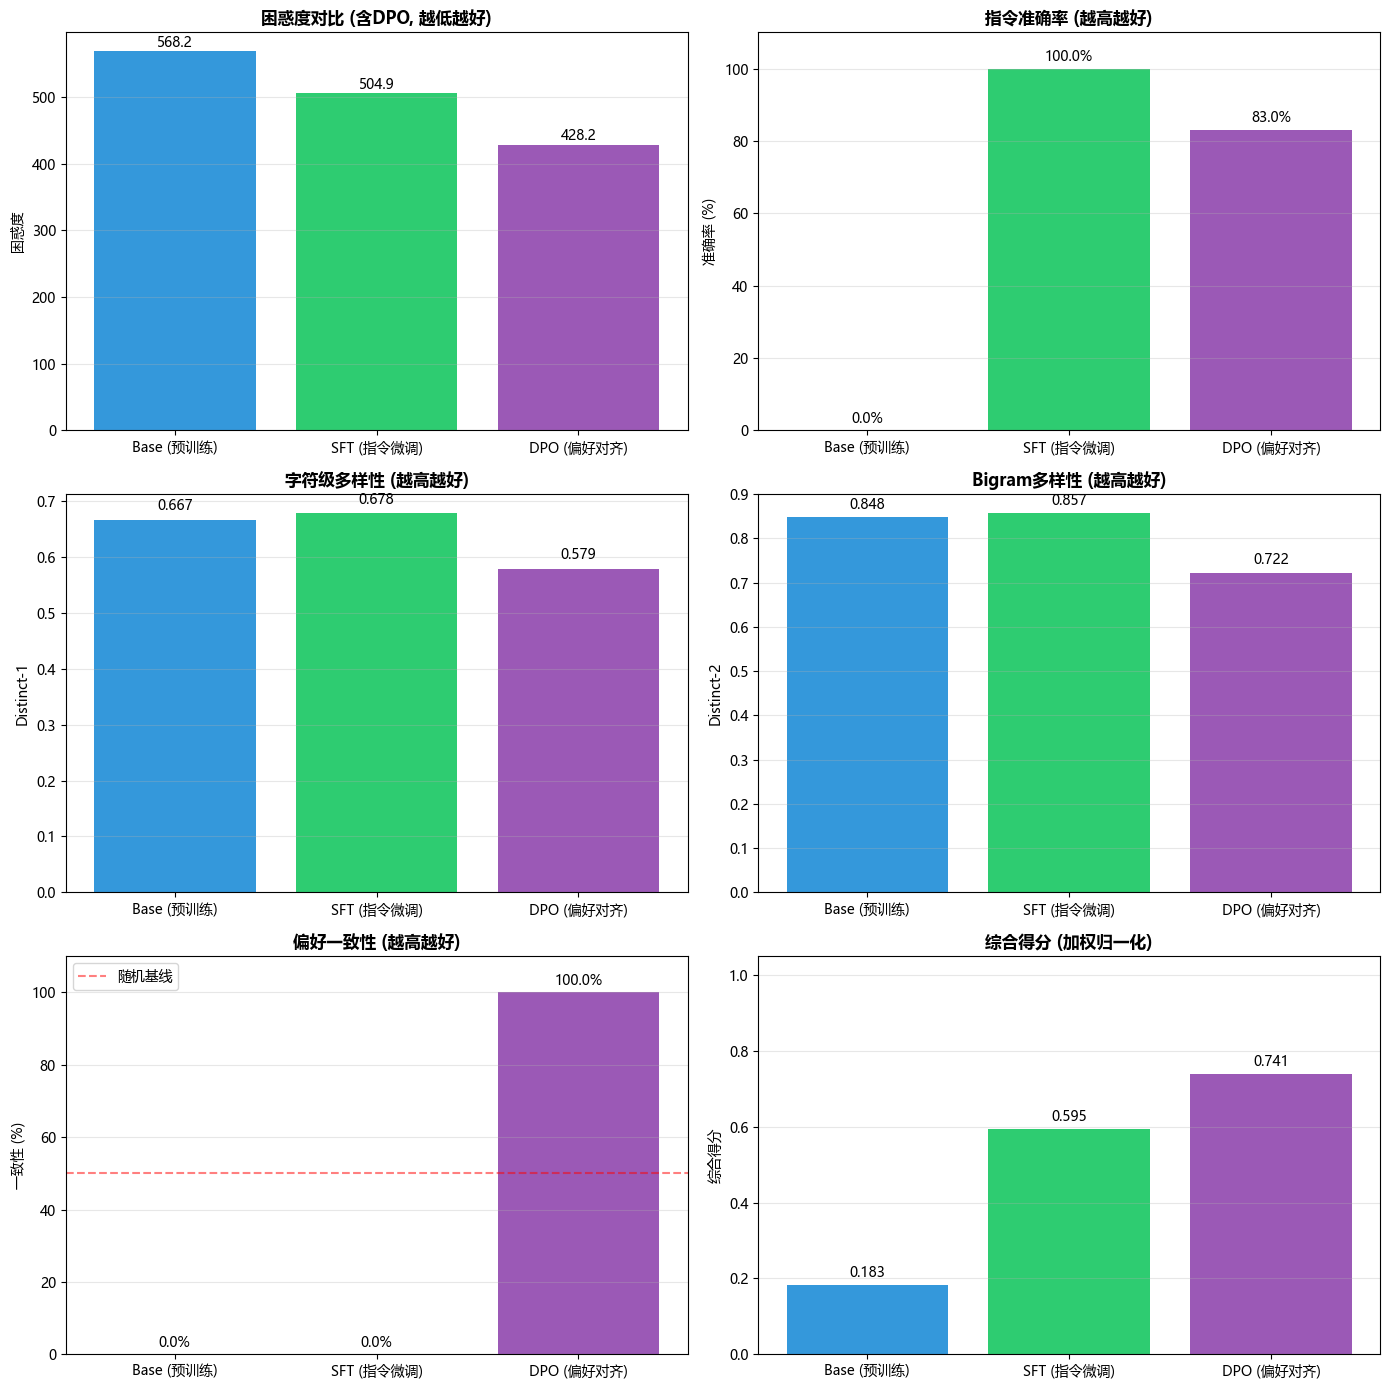


评估结果已保存至: c:\Users\lvbab\Documents\GitHub\LLM-Agent-Core_Concept_Code\models\custom_gpt/evaluation_results.png


In [89]:
# 可视化综合对比
fig, axes = plt.subplots(3, 2, figsize=(14, 14))

model_names = list(models.keys())
colors = ['#3498db', '#2ecc71', '#9b59b6']

# 1. 困惑度
ax = axes[0, 0]
ppl_names = [name for name in model_names if name in ppl_results]
values = [ppl_results[name] for name in ppl_names]
bars = ax.bar(ppl_names, values, color=colors[:len(ppl_names)])
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
            f'{val:.1f}', ha='center', va='bottom', fontsize=10)
ax.set_ylabel('困惑度')
ax.set_title('困惑度对比 (含DPO, 越低越好)', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# 2. 指令准确率
ax = axes[0, 1]
values = [instruction_results.get(name, {}).get('overall', 0)*100 for name in model_names]
bars = ax.bar(model_names, values, color=colors[:len(model_names)])
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f'{val:.1f}%', ha='center', va='bottom', fontsize=10)
ax.set_ylabel('准确率 (%)')
ax.set_title('指令准确率 (越高越好)', fontweight='bold')
ax.set_ylim(0, 110)
ax.grid(True, alpha=0.3, axis='y')

# 3. Distinct-1
ax = axes[1, 0]
values = [diversity_results.get(name, (0,0))[0] for name in model_names]
bars = ax.bar(model_names, values, color=colors[:len(model_names)])
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{val:.3f}', ha='center', va='bottom', fontsize=10)
ax.set_ylabel('Distinct-1')
ax.set_title('字符级多样性 (越高越好)', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# 4. Distinct-2
ax = axes[1, 1]
values = [diversity_results.get(name, (0,0))[1] for name in model_names]
bars = ax.bar(model_names, values, color=colors[:len(model_names)])
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{val:.3f}', ha='center', va='bottom', fontsize=10)
ax.set_ylabel('Distinct-2')
ax.set_title('Bigram多样性 (越高越好)', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# 5. 偏好一致性
ax = axes[2, 0]
values = [sum(preference_results[name])/len(preference_results[name])*100 
          if name in preference_results else 0 for name in model_names]
bars = ax.bar(model_names, values, color=colors[:len(model_names)])
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
            f'{val:.1f}%', ha='center', va='bottom', fontsize=10)
ax.set_ylabel('一致性 (%)')
ax.set_title('偏好一致性 (越高越好)', fontweight='bold')
ax.set_ylim(0, 110)
ax.axhline(y=50, color='red', linestyle='--', alpha=0.5, label='随机基线')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

# 6. 综合得分
ax = axes[2, 1]
score_map = df.set_index('模型')['综合得分'].to_dict() if '综合得分' in df.columns else {}
values = [score_map.get(name, 0) for name in model_names]
bars = ax.bar(model_names, values, color=colors[:len(model_names)])
for bar, val in zip(bars, values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'{val:.3f}', ha='center', va='bottom', fontsize=10)
ax.set_ylabel('综合得分')
ax.set_title('综合得分 (加权归一化)', fontweight='bold')
ax.set_ylim(0, 1.05)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(CHECKPOINT_DIR, 'evaluation_results.png'), dpi=150, bbox_inches='tight')
plt.show()

print(f"\n评估结果已保存至: {CHECKPOINT_DIR}/evaluation_results.png")

## Part 7: 训练流程总结

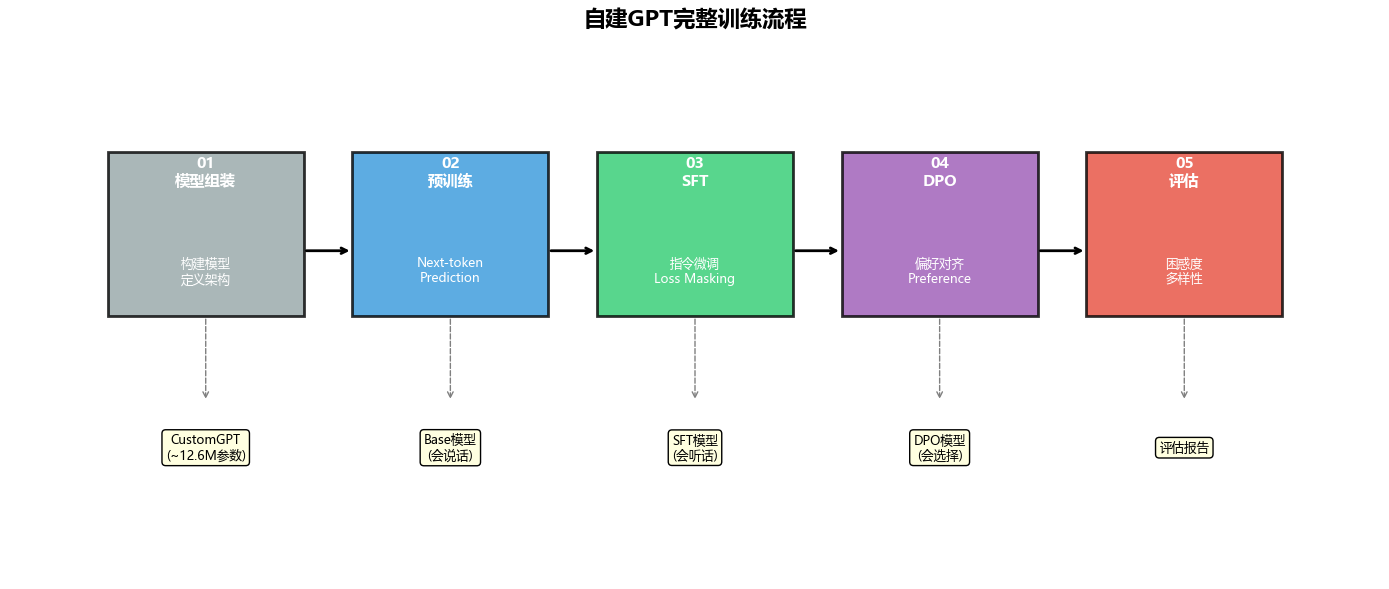

In [90]:
# 训练流程图
fig, ax = plt.subplots(figsize=(14, 6))
ax.set_xlim(0, 14)
ax.set_ylim(0, 8)
ax.axis('off')
ax.set_title('自建GPT完整训练流程', fontsize=16, fontweight='bold', pad=20)

# 颜色
colors = {
    'pretrain': '#3498db',
    'sft': '#2ecc71',
    'dpo': '#9b59b6',
    'eval': '#e74c3c'
}

# 阶段框
stages = [
    (1, 5, '01\n模型组装', '构建模型\n定义架构', '#95a5a6'),
    (3.5, 5, '02\n预训练', 'Next-token\nPrediction', colors['pretrain']),
    (6, 5, '03\nSFT', '指令微调\nLoss Masking', colors['sft']),
    (8.5, 5, '04\nDPO', '偏好对齐\nPreference', colors['dpo']),
    (11, 5, '05\n评估', '困惑度\n多样性', colors['eval']),
]

for x, y, title, desc, color in stages:
    # 框
    rect = plt.Rectangle((x, y-1), 2, 2.5, color=color, ec='black', linewidth=2, alpha=0.8)
    ax.add_patch(rect)
    # 标题
    ax.text(x+1, y+1.2, title, ha='center', va='center', fontsize=11, fontweight='bold', color='white')
    # 描述
    ax.text(x+1, y-0.3, desc, ha='center', va='center', fontsize=9, color='white')

# 箭头
arrow_style = dict(arrowstyle='->', color='black', lw=2)
for i in range(4):
    ax.annotate('', xy=(stages[i+1][0], 5), xytext=(stages[i][0]+2, 5),
                arrowprops=arrow_style)

# 模型输出
outputs = [
    (2, 2, 'CustomGPT\n(~12.6M参数)'),
    (4.5, 2, 'Base模型\n(会说话)'),
    (7, 2, 'SFT模型\n(会听话)'),
    (9.5, 2, 'DPO模型\n(会选择)'),
    (12, 2, '评估报告'),
]

for x, y, text in outputs:
    ax.annotate(text, xy=(x, y), ha='center', va='center', fontsize=9,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='lightyellow', edgecolor='black'))
    ax.annotate('', xy=(x, 2.7), xytext=(x, 4),
                arrowprops=dict(arrowstyle='->', color='gray', lw=1, ls='--'))

plt.tight_layout()
plt.show()

## 总结

### 完整训练流程回顾

```
01_Model_Assembly.ipynb
├── 构建CustomGPT模型 (~12.6M参数)
├── RoPE位置编码 + RMSNorm + SwiGLU
└── 输出: 随机初始化的模型

02_Pretraining.ipynb
├── Next-token Prediction任务
├── 学习语言的统计规律
└── 输出: Base模型（会"说话"）

03_SFT_Training.ipynb
├── ChatML格式的指令数据
├── Loss Masking（只对回答计算loss）
└── 输出: SFT模型（会"听话"）

04_DPO_Training.ipynb
├── (chosen, rejected)偏好对数据
├── 直接优化偏好概率差异
└── 输出: DPO模型（会"选择"）

05_Evaluation.ipynb (本notebook)
├── 困惑度评估
├── 指令遵循能力
├── 生成多样性
└── 偏好一致性
```

### 各阶段模型特点

| 模型 | 能力 | 特点 |
|------|------|------|
| Base | 文本续写 | 理解语言规律，但不懂指令 |
| SFT | 指令遵循 | 理解用户意图，生成相关回答 |
| DPO | 偏好对齐 | 倾向生成人类偏好的回答 |

### 关键技术点

1. **小模型优势**: ~12.6M参数，CPU可训练，适合学习和实验
2. **Loss Masking**: SFT中只对assistant部分计算loss
3. **DPO算法**: 无需Reward Model，直接从偏好数据学习
4. **完整pipeline**: 从零到可用的完整训练流程

### 与HuggingFace GPT-2训练的对比

| 维度 | 自建GPT | HuggingFace GPT-2 |
|------|---------|-------------------|
| 参数量 | ~12.6M | 124M+ |
| 训练设备 | CPU/GPU | 需要GPU |
| 透明度 | 完全透明 | 部分黑盒 |
| 定制性 | 高 | 中 |
| 性能 | 学习/演示用 | 生产可用 |

恭喜完成本教程包含的:
- 学习LLM训练原理
- 快速实验新想法
- 资源受限场景
- 教学演示